# (04) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 3
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:3  ———  host: mach

## BALLS

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('BALLS16', model_type, 'jacob|conv')

cfg_vae['n_latents'] = [32]
cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 16

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 200
cfg_tr['batch_size'] = 128
cfg_tr['kl_beta'] = 1.0
cfg_tr['kl_balancer'] = None

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'BALLS16', 'n_latents': [32], 'prior_clamp': -2, 'enc_type': 'jacob', 'dec_type': 'conv', 'enc_bias': 
False, 'dec_bias': False, 'init_dist': 't', 'init_scale': 0.01, 'seq_len': 16}

Trainer:
{'epochs': 200, 'batch_size': 128, 'optimizer_kws': {'weight_decay': 0.0001}, 'grad_clip': 250, 'kl_const_portion':
0.01, 'lr': 0.002, 'kl_beta': 1.0, 'kl_balancer': None}

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  365.9 K   |
|     ———     |    ———     |
|  layers.L_0 |  365.9 K   |
+-------------+------------+

poisson_uniform_c(-2)_BALLS16_t-16_z-[32]_k-32_<jacob|conv>
mc_b128-ep200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(250)_(2024_09_04,16:01)

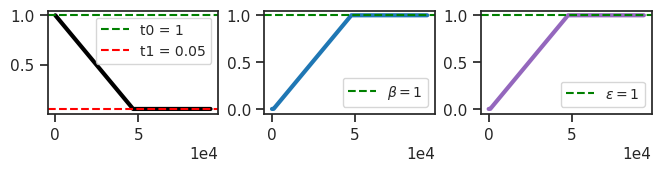

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
tr.n_iters

93600

In [7]:
print_num_params(tr.model.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  365.9 K   |
|     ———      |    ———     |
|    fc_dec    |   65.5 K   |
|     dec      |  300.3 K   |
+--------------+------------+

### Fit model

In [ ]:
tr.train()

epoch # 11, avg loss: 1.944352:   6%|███                                                    | 11/200 [1:29:32<25:33:03, 486.69s/it]

In [ ]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
bias = tonp(tr.model.input_layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [ ]:
dead = log_rate > -0.4
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

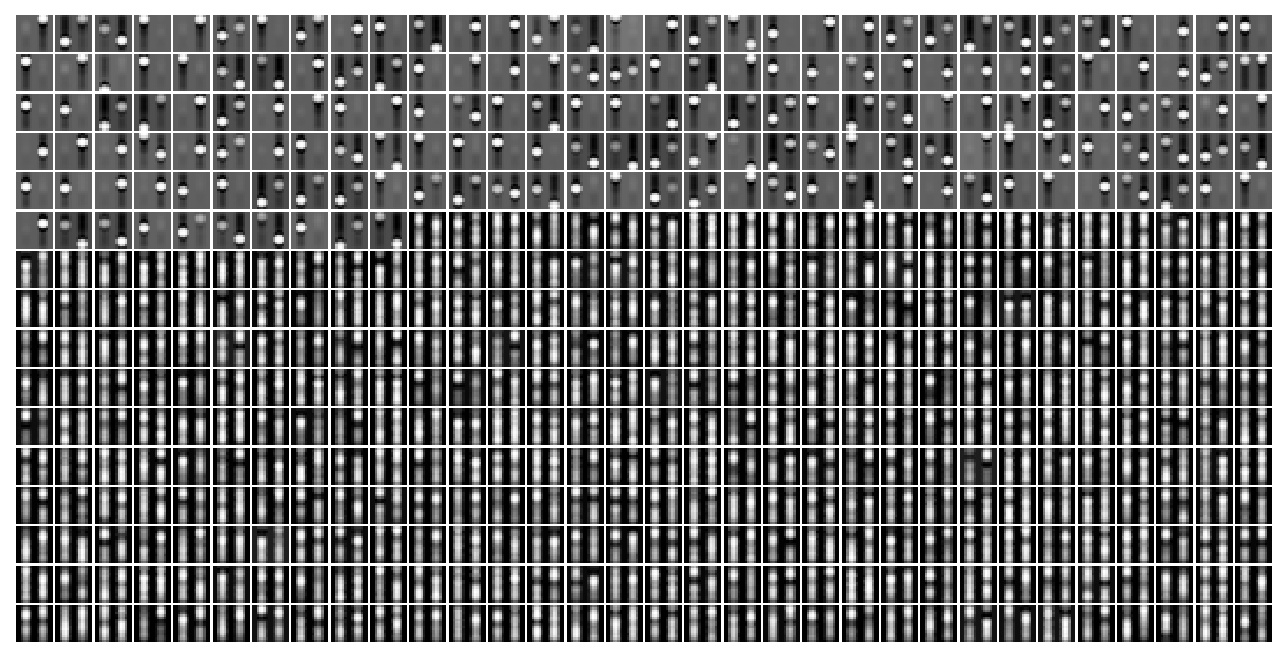

In [23]:
try:
    tr.model.show(nrows=16, order=np.argsort(dead))
except AttributeError:
    print(tr.model.cfg.dec_type)

In [18]:
%%time

kws = dict(
    seq_total=30000,
    seq_batch_sz=1000,
    n_data_batches=5,
    active=~dead,
    verbose=True,
    full_data=True,
    return_recon=False,
)
results = {
    name: tr.analysis(dl_name=name, **kws)
    for name in ['trn', 'vld', 'tst']
}

100%|███████████████████████████████████| 5/5 [05:29<00:00, 65.95s/it]


CPU times: user 13min 27s, sys: 5min 58s, total: 19min 26s
Wall time: 19min 54s


______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

trn

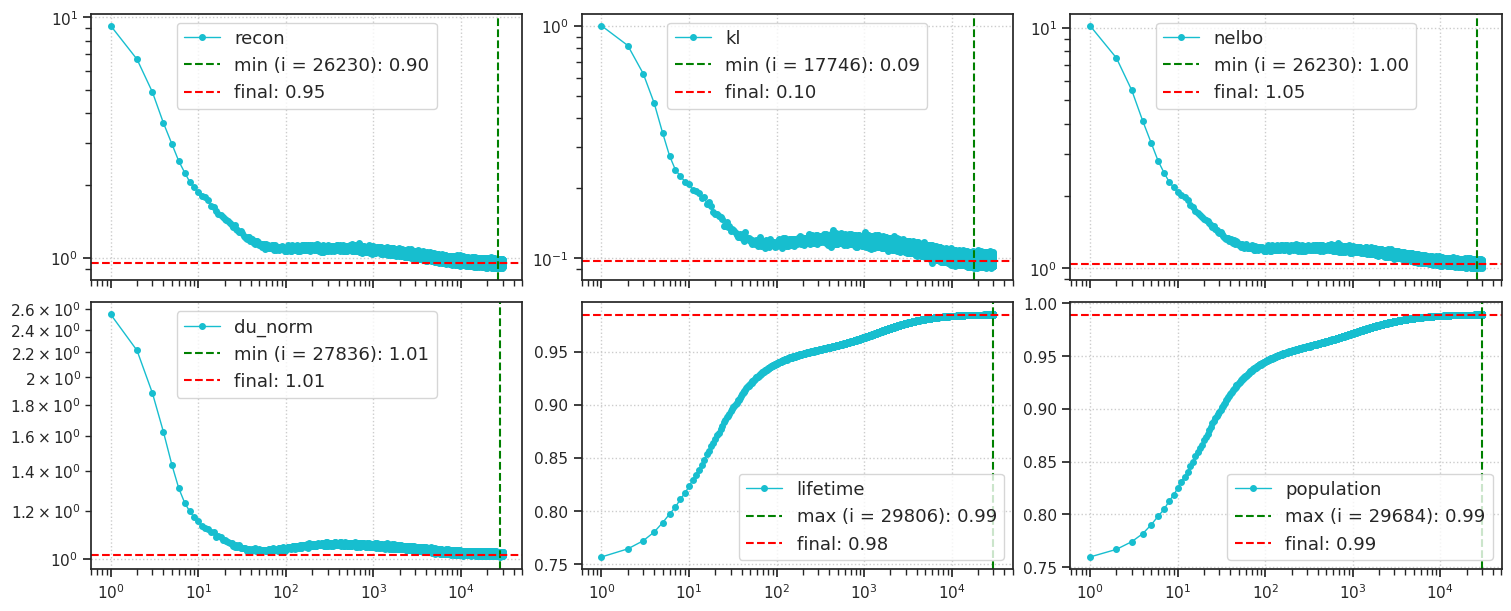

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

vld

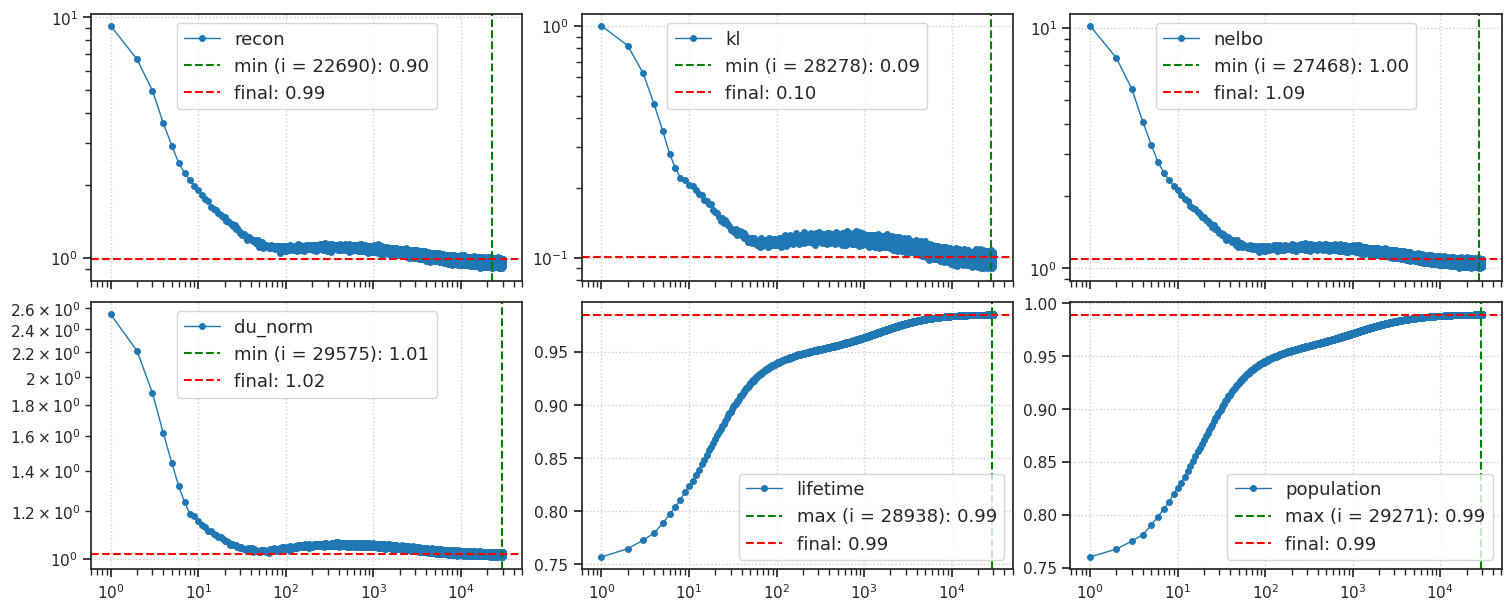

______________________________________________________________________________________________________________

--------------------------------------------------------------------------------------------------------------

tst

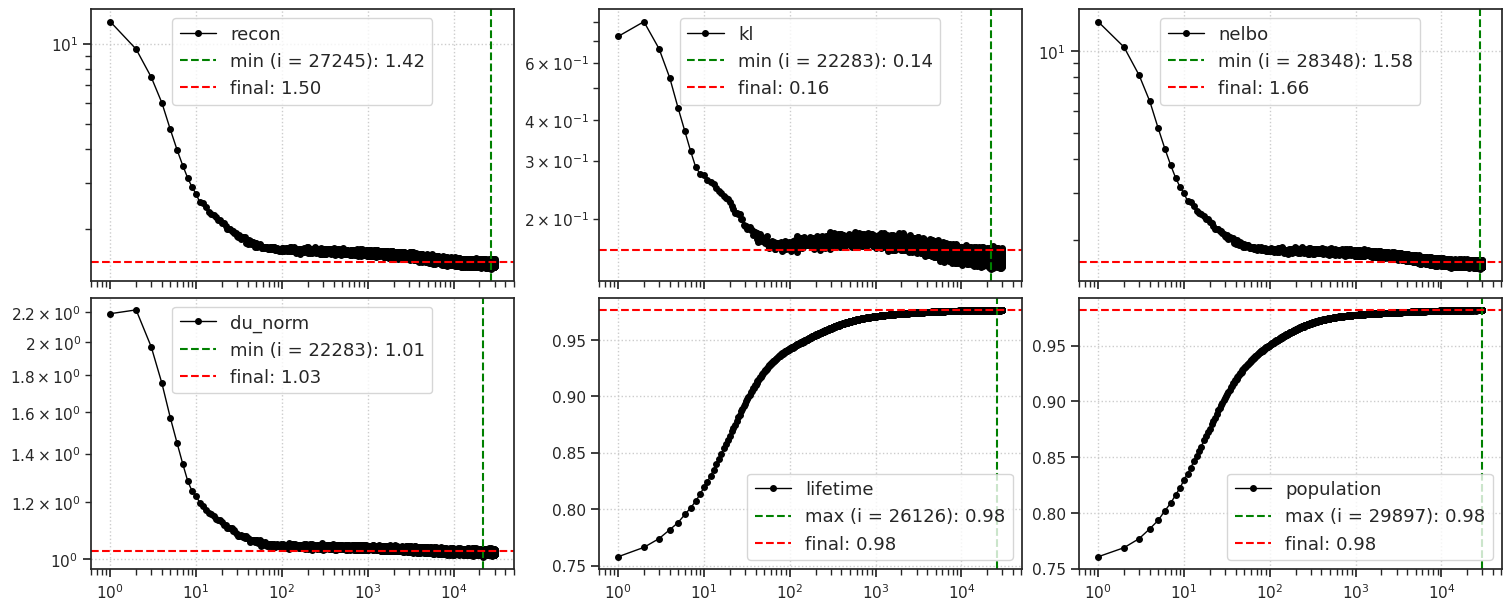

In [19]:
colors = {'trn': 'C9', 'vld': 'C0', 'tst': 'k'}
for name, d in results.items():
    if name != 'trn':
        print('\n\n\n')
    print('_' * 110)
    print('-' * 110)
    print(name)

    plot_convergence(d, color=colors[name])

In [20]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

In [21]:
var = 'state_final'

lr = LinearRegression().fit(
    X=results['trn'][var][:, ~dead],
    y=results['trn']['g'][:, [1, 3]],
)
r2 = {
    name: r2_score(
        y_true=d['g'][:, [1, 3]],
        y_pred=lr.predict(d[var][:, ~dead]),
        multioutput='raw_values')
    for name, d in results.items()
}
corr = {
    name: 1 - np.diag(sp_dist.cdist(
        XA=d['g'][:, [1, 3]].T,
        XB=lr.predict(d[var][:, ~dead]).T,
        metric='correlation',
    )) for name, d in results.items()
}

In [22]:
print('r2:')
display(r2)
print('\n')
print('corr:')
display(corr)

r2:

{'trn': array([0.98082217, 0.98165729]),
 'vld': array([0.97917642, 0.97929624]),
 'tst': array([-4.9214041 , -3.27083451])}

corr:

{'trn': array([0.99036698, 0.99079938]),
 'vld': array([0.98954158, 0.98962286]),
 'tst': array([0.85649165, 0.89058029])}